In [20]:
import torch
import matplotlib.pyplot as plt
import os


# Random nubers

Based on the Wichmann Hill algorithm used before Python 2.3.

In [16]:
rnd_state = None
def seed(a):
  global rnd_state
  a, x = divmod(a, 30268)
  a, y = divmod(a, 30306)
  a, z = divmod(a, 30322)
  rnd_state = int(x)+1, int(y)+1, int(z)+1

In [17]:
seed(457428938475)
rnd_state

(4976, 20238, 499)

In [18]:
def rand():
  global rnd_state
  x, y, z = rnd_state
  x = (171 * x) % 30269
  y = (172 * y) % 30307
  z = (170 * z) % 30323
  rnd_state = x,y,z
  return (x/30269 + y/30307 + z/30323) % 1.0

In [19]:
rand(), rand(), rand()

(0.7645251082582081, 0.7920889799553945, 0.06912886811267205)

Issue with random number generation read [here](https://mlops.systems/computervision/fastai/parttwo/2022/10/24/foundations-mnist-basics.html#Generate-some-random-numbers) for more 

In [25]:
if os.fork():
  print(f'Inparent: {rand()}')
else:
  print(f'In child: {rand()}')
  os._exit(os.EX_OK)

Inparent: 0.15532781424845843
In child: 0.15532781424845843


In [34]:
if os.fork():
  print(f'Inparent: {torch.rand(1)}')
else:
  print(f'In child: {torch.rand(1)}')
  os._exit(os.EX_OK)


Inparent: tensor([0.1449])
In child: tensor([0.1449])


In [30]:
import numpy as np

In [33]:
if os.fork():
  print(f'Inparent: {np.random.rand(1)}')
else:
  print(f'In child: {np.random.rand(1)}')
  os._exit(os.EX_OK)

Inparent: [0.15557271]
In child: [0.15557271]


In [27]:
from random import random 

In [28]:
if os.fork():
  print(f'Inparent: {random()}')
else:
  print(f'In child: {random()}')
  os._exit(os.EX_OK)

Inparent: 0.07139119726508514
In child: 0.11867943639224843


random numbers should have no correlation between them 

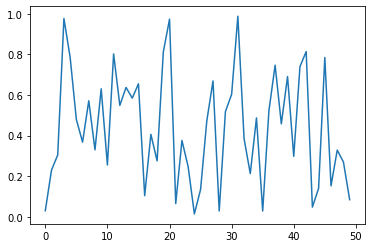

In [37]:
plt.plot([rand() for _ in range(50)]);

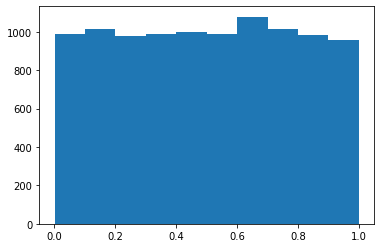

In [38]:
plt.hist([rand() for _ in range(10000)]);

In [45]:
def chunks(x, size):
    for i in range(0, len(x), size): 
        yield x[i:i + size]

In [43]:
print([i for i in range(10)])

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]


In [46]:
%timeit -n 10 list(chunks([rand() for _ in range(7840)],10))

16.7 ms ± 4.04 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [47]:
%timeit -n 10 torch.randn(784,10)

The slowest run took 16.73 times longer than the fastest. This could mean that an intermediate result is being cached.
409 µs ± 530 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
